In [1]:
using GuidedProposals, DiffusionDefinition, ObservationSchemes
const GP = GuidedProposals
const DD = DiffusionDefinition
const OBS = ObservationSchemes

using StaticArrays, Random, Plots, LinearAlgebra
using Statistics

# seed used for this tutorial
Random.seed!(100)

## data generation ##
@diffusion_process FavettoSamsonModified{T,K} begin
    :dimensions
    process --> 2
    wiener --> 2

    :parameters
    (α, β, λ, μ, σ1, σ2) --> T
    dose --> K

    :additional
    diagdiff --> true
    constdiff --> true
end

DiffusionDefinition.b(t, x, P::FavettoSamsonModified) = @SVector [
    P.α * P.dose(t) - (P.λ +P.β)*x[1] + (P.μ-P.λ)*x[2],
    P.λ*x[1] - (P.μ-P.λ)*x[2]
]

DiffusionDefinition.σ(t, x, P::FavettoSamsonModified) = SDiagonal(P.σ1, P.σ2)

A new struct `FavettoSamsonModified{T, K}` has been defined.


In [2]:
θ = [116.7, 5.83, 1.25, 2.25, 2.0, 1.0]
P_target = FavettoSamsonModified(θ..., t->t/(1+t^2))
tt, y1 = 0.0:0.0001:10.0, @SVector [0.0, 0.0]
X = rand(P_target, tt, y1)

data = map(
    x->(x[1], x[2] + 0.8randn()),
    collect(zip(X.t, X.x))[1:1000:end]
)[2:end]

data1 = map(
    x->(x[1], x[2][1] + x[2][2] + randn()),
    collect(zip(X.t, X.x))[1:1000:end]
)[2:end]

data2 = map(
    x->(x[1], x[2][1] + 0.8randn()),
    collect(zip(X.t, X.x))[1:1000:end]
)[2:end]

data3 = map(
    x->(x[1], x[2][2] + 0.8randn()),
    collect(zip(X.t, X.x))[1:1000:end]
)[2:end]

100-element Vector{Tuple{Float64, Float64}}:
 (0.1, -1.365865046289156)
 (0.2, -0.48444450537181327)
 (0.3, 0.9766360914511272)
 (0.4, 0.2641772378738458)
 (0.5, 1.703912143536825)
 (0.6, 1.3907093496455052)
 (0.7, 1.4958023392229127)
 (0.8, 3.691209066986951)
 (0.9, 2.873481251934531)
 (1.0, 4.268047547084274)
 (1.1, 3.52156383194186)
 (1.2, 4.684665575649791)
 (1.3, 4.438465430954867)
 ⋮
 (8.9, 1.4380795950457335)
 (9.0, 0.6625168253384829)
 (9.1, 1.2490698968293652)
 (9.2, 2.686301809216264)
 (9.3, 1.9823266299119513)
 (9.4, 3.1726619960208287)
 (9.5, 3.3122576408106115)
 (9.6, 3.474436548592468)
 (9.7, 4.138828940916456)
 (9.8, 2.6477423039279477)
 (9.9, 2.82014638960816)
 (10.0, 2.681202900436357)

In [3]:
# let's examine the data
plot(X, Val(:vs_time), size=(800, 300))
scatter!(map(x->x[1], data), map(x->x[2][1], data), label="data")

In [4]:
recording = (
    #P = FavettoSamsonModified([10, 5, #==# 0.0 #==#, 2, 1, 1]..., t-> 1/(1+t^2)),
    P = FavettoSamsonModified([116.7, 5.83, 1.25, 2.25, 2.0,#==# 0.0 #==# ]..., t->t/(1+t^2)), # diffusion law
    obs = load_data(
        ObsScheme(
            LinearGsnObs(
                0.0, (@SVector [0.0]); # dummy variables indicating datatype of observations
                L=(@SMatrix [0.0 1.0]), # observation operator
                Σ=(@SMatrix [0.64]) #1e-2*SDiagonal{2,Float64}(I) # noise on the observations
            )
        ),
        data3
    ),
    t0 = 0.0,
    x0_prior = KnownStartingPt(y1),
)

(P = FavettoSamsonModified{Float64, var"#15#16"}(116.7, 5.83, 1.25, 2.25, 2.0, 0.0, var"#15#16"()), obs = LinearGsnObs{0, 1, SVector{1, Float64}, NoFirstPassageTimes, SMatrix{1, 2, Float64, 2}, SVector{1, Float64}, SMatrix{1, 1, Float64, 1}, Any}[LinearGsnObs{0, 1, SVector{1, Float64}, NoFirstPassageTimes, SMatrix{1, 2, Float64, 2}, SVector{1, Float64}, SMatrix{1, 1, Float64, 1}, Any}([0.0 1.0], [0.0], [0.64], [-1.365865046289156], 0.1, false, Any[]), LinearGsnObs{0, 1, SVector{1, Float64}, NoFirstPassageTimes, SMatrix{1, 2, Float64, 2}, SVector{1, Float64}, SMatrix{1, 1, Float64, 1}, Any}([0.0 1.0], [0.0], [0.64], [-0.48444450537181327], 0.2, false, Any[]), LinearGsnObs{0, 1, SVector{1, Float64}, NoFirstPassageTimes, SMatrix{1, 2, Float64, 2}, SVector{1, Float64}, SMatrix{1, 1, Float64, 1}, Any}([0.0 1.0], [0.0], [0.64], [0.9766360914511272], 0.3, false, Any[]), LinearGsnObs{0, 1, SVector{1, Float64}, NoFirstPassageTimes, SMatrix{1, 2, Float64, 2}, SVector{1, Float64}, SMatrix{1, 1, F

In [5]:
@diffusion_process FavettoSamsonAux{K,Q,R} begin
    :dimensions
    process --> 2
    wiener --> 2

    :parameters
    (α, β, λ, μ, σ1, σ2) --> K
    dose --> Q
    :auxiliary_info
    t0 --> Float64
    T --> Float64
    vT --> R

    :additional
    constdiff --> true
    linear --> true
end

DiffusionDefinition.B(t, P::FavettoSamsonAux) = @SMatrix [-(P.λ+ P.β) P.β; P.λ -P.μ]
DiffusionDefinition.β(t, P::FavettoSamsonAux) = @SVector [P.α* P.dose(t), 0.0]
DiffusionDefinition.σ(t, P::FavettoSamsonAux) = SDiagonal(P.σ1, P.σ2)

@load_diffusion FavettoSamsonAux

A new struct `FavettoSamsonAux{K, Q, R}` has been defined.


In [6]:
"""
Adaptive readjustment for the `i`th recording of the preconditioned
Crank–Nicolson scheme's memory parameter.
"""
max_p, min_p = 1e7, 1e-12
target_rate = 0.44
# define a time delay
offset = 9.6

function readjust(p_old, accpt_r, δ, mcmc_iter)
    p = sigmoid(logit(p_old)-(2*(accpt_r > target_rate)-1)* δ)
    p = max.(min.(p,  max_p), min_p)
end

sigmoid(x, a=1.0) = 1.0 / (1.0 + exp(-a*x))
logit(x, a=1.0) = (log(x) - log(1-x))/a

"""
    compute_δ(p, mcmc_iter)
δ decreases roughly proportional to scale/sqrt(iteration)
"""
function compute_δ(mcmc_iter)
    1.0 / sqrt(
        max(1.0, mcmc_iter/100 -offset)
    )
end

compute_δ

In [7]:
# define a transition kernel for θ
function customkernel(θ, s::Symbol, scale=0.1)
	θ° = deepcopy(θ)
	θ°[s] += 2.0*scale*(rand()-0.5)
	θ°
end

customkernel (generic function with 2 methods)

In [8]:
function GaussianRandomWalk(Σ, pos=nothing)
    @assert size(Σ, 1) == size(Σ, 2)
    Σ = reshape(Σ, (size(Σ, 1), size(Σ, 2)))
     T = eltype(Σ)
    pos = (pos === nothing) ? fill(false, size(Σ, 1)) : pos
    new{T}(Symmetric(Σ), pos)
end

GaussianRandomWalk (generic function with 2 methods)

In [9]:
function simple_inference(AuxLaw, recording, dt, θ, s::Symbol; ρ=0.5, q=0.2, num_steps=10^4)
	# initializations
	tts = OBS.setup_time_grids(recording, dt)
	PP = build_guid_prop(AuxLaw, recording, tts)
	PP° = deepcopy(PP)

	y1 = rand(recording.x0_prior) # just returns the starting point
	XX, WW, Wnr = rand(PP, y1)
	XX°, WW° = trajectory(PP)

	ll = loglikhd(PP, XX)
	paths = []
	θθ = Float64[θ[s],]
    err_list = Float64[0,]
    p_list = Float64[θ[s],]
    p_mean = θ[s]
    ssq = p_mean^2
	imp_a_r = 0
	param_a_r = 0

	# MCMC
	for i in 1:num_steps
		# impute a path
		_, ll° = rand!(PP, XX°, WW°, WW, ρ, Val(:ll), y1; Wnr=Wnr)

		if rand() < exp(ll°-ll)
			XX, WW, XX°, WW° = XX°, WW°, XX, WW
			ll = ll°
			imp_a_r += 1
		end

		# update parameter
        θ° = customkernel(θ, s, q)
		DD.set_parameters!(PP°, θ°)
		recompute_guiding_term!(PP°)
		_, ll° = GP.solve_and_ll!(XX°, WW, PP°, y1)

		if rand() < exp(ll°-ll) # uniform updates have no contribution to ll
			XX, PP, θ, XX°, PP°, θ° = XX°, PP°, θ°, XX, PP, θ
			ll = ll°
			param_a_r += 1
		end
		append!(θθ, [θ[s]])
        append!(p_list, [θ[s]])
        append!(err_list, [θ[s]-2.0])


		# progress message
		if i % 100 == 0
			println(
				"$i. ll=$ll, estimate=$(θ[s]), imp accpt rate: $(imp_a_r/100), ",
				"updt accpt rate: $(param_a_r/100)"
			)
            accpt_r = imp_a_r / 100
#             accpt_r = param_a_r/100
            δ = compute_δ(i)
            ρ = readjust(ρ, accpt_r, δ, i)
			imp_a_r = param_a_r = 0
            
            # now update transition kernel q
#             d = length(p_list)
#             p_mean = p_mean * d / (d+1) + θ[:λ] / (d+1)
#             ssq += θ[:λ]^2 / d
#             v = ssq - (d+1) / d * p_mean^2
#             q = 2.38^2 / d * v
#             p_list = []
            
		end

		# save intermediate path for plotting
		i % 400 == 0 && append!(paths, [deepcopy(XX)])
	end
	paths, θθ,err_list
end

simple_inference (generic function with 1 method)

In [10]:
# let's declare which parameters are not changing
DD.const_parameter_names(::Type{<:FavettoSamsonModified}) = (:α,:β, :λ,:μ, :σ1) 
DD.const_parameter_names(::Type{<:FavettoSamsonAux}) = (:α,:β,:λ,:μ, :σ1, :t0, :T, :vT, :xT)
# and do the inference
paths, θθ,err_list = simple_inference(
	FavettoSamsonAux, recording, 0.001, Dict(:σ2 => 0.0), :σ2; ρ= 0.5, q=0.2, num_steps= 10^4
) 

100. ll=-125.13531252226896, estimate=1.1496583707258665, imp accpt rate: 0.11, updt accpt rate: 0.81
200. ll=-125.29254534507791, estimate=1.2629373126682535, imp accpt rate: 0.06, updt accpt rate: 0.73
300. ll=-118.59617708924931, estimate=1.6056408716842556, imp accpt rate: 0.15, updt accpt rate: 0.84
400. ll=-109.74259672162604, estimate=0.9232996050168778, imp accpt rate: 0.35, updt accpt rate: 0.81
500. ll=-103.5470938312693, estimate=1.3121615410484908, imp accpt rate: 0.44, updt accpt rate: 0.73
600. ll=-103.72689448493634, estimate=1.2543604358703107, imp accpt rate: 0.64, updt accpt rate: 0.76
700. ll=-108.8172477544861, estimate=1.2212883114442608, imp accpt rate: 0.51, updt accpt rate: 0.72
800. ll=-106.78950326815158, estimate=1.0699144105166918, imp accpt rate: 0.24, updt accpt rate: 0.8
900. ll=-115.51939742186187, estimate=1.2705286856565585, imp accpt rate: 0.54, updt accpt rate: 0.78
1000. ll=-104.80208546269893, estimate=1.320244862520371, imp accpt rate: 0.34, updt 

8200. ll=-109.45219936086434, estimate=1.284715833952153, imp accpt rate: 0.45, updt accpt rate: 0.78
8300. ll=-108.0470922541887, estimate=1.2782290608088396, imp accpt rate: 0.27, updt accpt rate: 0.85
8400. ll=-109.6474412775242, estimate=1.3570698324519244, imp accpt rate: 0.46, updt accpt rate: 0.85
8500. ll=-120.28513752480906, estimate=1.1878425921047588, imp accpt rate: 0.41, updt accpt rate: 0.82
8600. ll=-119.07900083934759, estimate=1.111978769869132, imp accpt rate: 0.5, updt accpt rate: 0.85
8700. ll=-115.54505335399207, estimate=1.1257172098243247, imp accpt rate: 0.4, updt accpt rate: 0.75
8800. ll=-107.19530890884104, estimate=1.3236829781468678, imp accpt rate: 0.43, updt accpt rate: 0.88
8900. ll=-103.05880153968872, estimate=1.0331068010634838, imp accpt rate: 0.47, updt accpt rate: 0.79
9000. ll=-96.29810600114997, estimate=1.176485872531737, imp accpt rate: 0.35, updt accpt rate: 0.73
9100. ll=-99.82680493105542, estimate=1.537912092919364, imp accpt rate: 0.46, up

(Any[Trajectory{Vector{Float64}, Vector{SVector{2, Float64}}}[Trajectory{Vector{Float64}, Vector{SVector{2, Float64}}}([0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009  …  0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099, 0.1], SVector{2, Float64}[[0.0, 0.0], [-0.14110382310155653, -0.012040339650304245], [-0.17233830181825024, -0.03471475934587656], [-0.17928522384277984, -0.029217436993756316], [-0.11779903467105937, -0.03968867117071963], [-0.20358303791594073, -0.07937961927909831], [-0.290668780444981, -0.08531866683375433], [-0.3884255068327397, -0.07764044449153834], [-0.47585497256473525, -0.06377103572407412], [-0.4266931549362254, -0.09180941687735925]  …  [0.7048964610358823, 0.014020246052209244], [0.7413919128980032, -0.0340804544725907], [0.7480328093353921, -0.08594228820911165], [0.6752539199612844, -0.06347882212517111], [0.653490565786241, -0.0844985409309932], [0.6725554273792015, -0.05722632557686662], [0.7440723225084389, -0.07030873

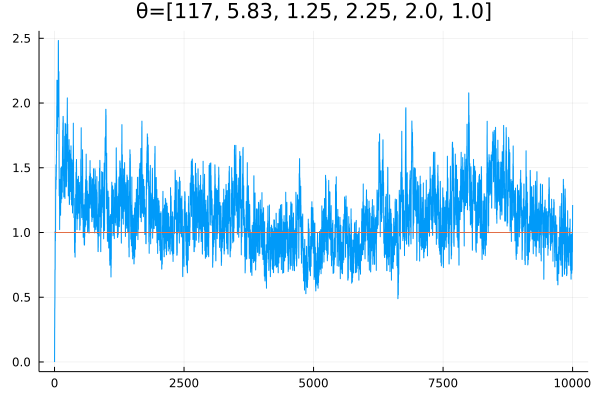

In [11]:
p1 = plot(θθ, title = "θ=[117, 5.83, 1.25, 2.25, 2.0, 1.0]",label="")
plot!(θθ->1.0,label="")
display(p1)
savefig("infer_σ2.png")

In [12]:
std(err_list)

0.2466265744172247